<a href="https://colab.research.google.com/github/vinaykumar2491/Project_MachineLearning/blob/master/imflash217_fastai_2_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating your own dataset from google images
```
In this tutorial we will see how to create our own dataset from google images.
NOTE: we need to repeat this process for every new category we want form google images(eg. cats, dogs,  etc.).
```

In [0]:
### importing necessary libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import pathlib

##Step-1: Getting a list of URLs
```
1.1: Search and scroll
1.2: Download into file
1.3: Create directory and upload URLs into your workspace
```

### 1.1: Search and scroll
```
A. Go to Google-Images.
B. Search for the images you are interested in (more specific query --> better results --> less post-pruning).
C. Scroll down untill you've seen all the image syou want to download.
D. All the images you have seen now are available for download.
```
### 1.2: Download into file
```
E. Disable ad-blocking application in Chrome; otherwise `window.open()` command won't work.
F. Press CTRL+SHIFT+J in Win/Linux to open Javascript Console in Chrome.
G. Run/Type the following javascript commands into the console:
```
------------------
```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
------------------
### 1.3: Create directory and upload these URLs files into your workspace
```
H. Choose an appropriate name for your labelled images.
I. Repeat steps A-to-H multiple times to download different types of labelled image dataset.
J. Upload these URLs-files into your workspace
```

In [0]:
classes = ["black", "teddys", "grizzly"]
URLs_files = ["urls_black.csv", "urls_teddys.csv", "urls_grizzly.csv"]
path = pathlib.Path("data/bears")

for folder in classes:
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [25]:
# !apt install tree
!tree .

.
├── data
│   └── bears
│       ├── black
│       ├── grizzly
│       ├── teddys
│       ├── urls_black.csv
│       ├── urls_grizzly.csv
│       └── urls_teddys.csv
└── sample_data
    ├── anscombe.json
    ├── california_housing_test.csv
    ├── california_housing_train.csv
    ├── mnist_test.csv
    ├── mnist_train_small.csv
    └── README.md

6 directories, 9 files


##Step-2: Download Images

In [0]:
max_pics = 200              ## maximum number of images to be downloaded
for idx, folder in enumerate(classes):
    download_images(urls=path/URLs_files[idx], dest=path/folder, max_pics=max_pics)

In [0]:
### remove any images that can't be opened
for c in classes:
    print(c)
    verify_images(path=path/c, delete=True, max_size=500)

In [40]:
## Checking for the total number of legit images for each category
for c in classes:
    print(c)
    ! ls data/bears/"{c}" | wc -l

black
184
teddys
187
grizzly
180


## Step-3: View data

In [0]:
### setting the random seed for reproducibilty
np.random.seed(217)

In [0]:
data = ImageDataBunch.from_folder(path=path, valid_pct=0.2, ds_tfms=get_transforms(),
                                  size=224, num_workers=4).normalize(imagenet_stats)

In [45]:
data.classes

['black', 'grizzly', 'teddys']

In [46]:
data.c

3

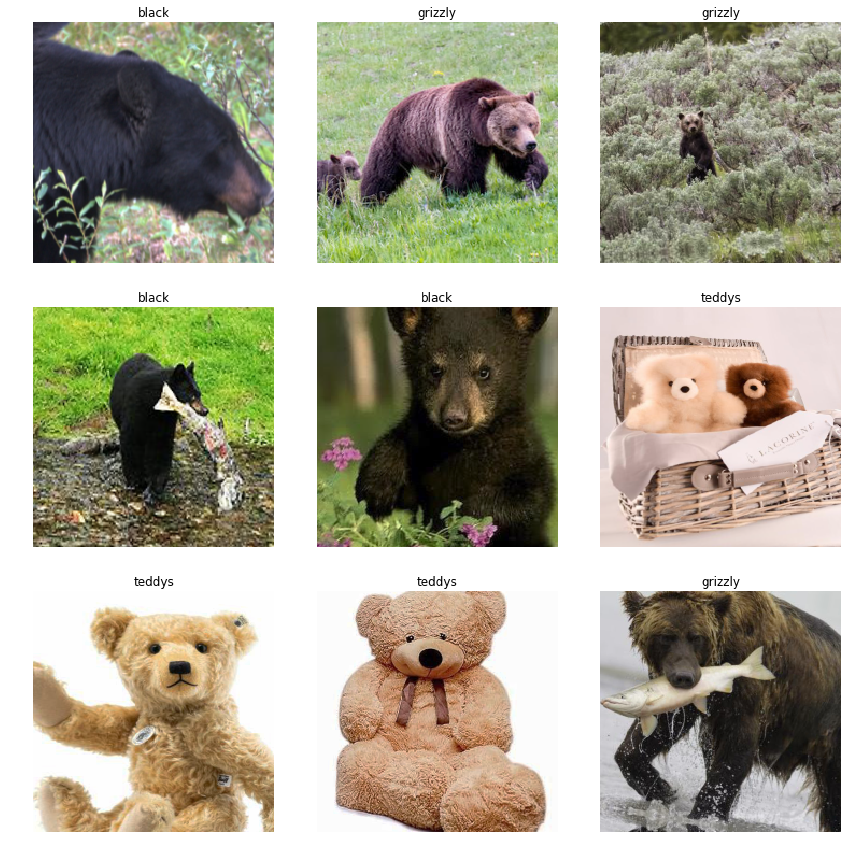

In [47]:
data.show_batch(rows=3, fig_size=(11,10))

In [48]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 437, 109)

## Step-4: Train model

In [50]:
### Creating a CNN learner and training it using fit_one_cycle()
learner = cnn_learner(data=data, base_arch=models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s] 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


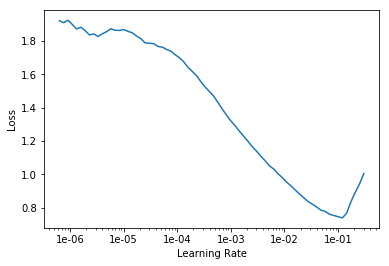

In [51]:
learner.lr_find()
learner.recorder.plot()

In [54]:
learner.fit_one_cycle(cyc_len=4)

epoch,train_loss,valid_loss,error_rate,time
0,1.192271,0.138713,0.045872,00:09
1,0.675942,0.069348,0.027523,00:08
2,0.451552,0.061245,0.018349,00:08
3,0.360394,0.062246,0.018349,00:08


In [0]:
learner.save("resnet34_stage1")

In [0]:
### unfreezing the pretrained layers of the model, so that it can be trained end-to-end
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


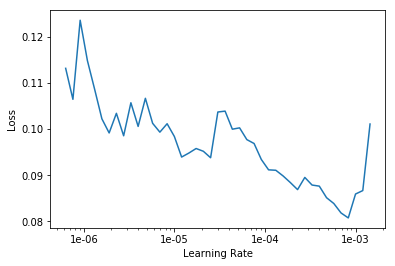

In [57]:
### finding the learning rate using lr_find
learner.lr_find()
learner.recorder.plot()

In [59]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.085745,0.081672,0.036697,00:09
1,0.054036,0.130208,0.036697,00:09
2,0.042502,0.116466,0.036697,00:09
3,0.036957,0.107824,0.036697,00:09


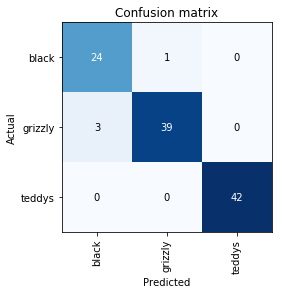

In [60]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [0]:
learner.save("resnet34_stage2")

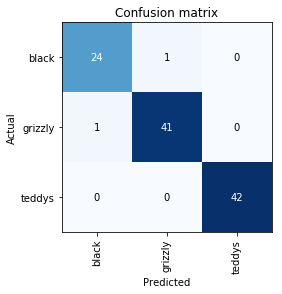

In [62]:
learner.load("resnet34_stage1")
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Step-7: Export the trained model

In [0]:
### Exporting the trained model
learner.export()

In [65]:
len(data.train_ds)

437

In [70]:
data.valid_ds[0]

(Image (3, 224, 224), Category black)

In [0]:
img = open_image(path/"black"/"00000021.jpg")

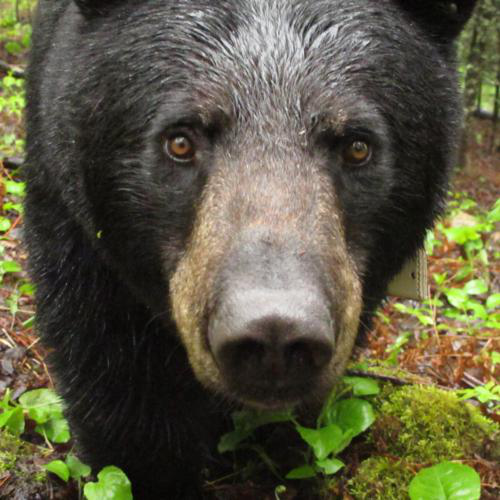

In [78]:
img

In [81]:
!ls data/bears

black	    grizzly  teddys	     urls_grizzly.csv
export.pkl  models   urls_black.csv  urls_teddys.csv


In [0]:
learner = load_learner(path)

In [83]:
pred_class, pred_idx, outputs = learner.predict(img)
pred_class, pred_idx

(Category black, tensor(0))

In [84]:
outputs

tensor([9.9918e-01, 8.2053e-04, 3.3823e-07])

In [0]:
learner.predict??

## Step-5: Interpret results

##Step-6: Cleanup